In [585]:
#Questions: Are the different coefficients uniform amongst all the nodes in the graph ? Right now, they are equal for all nodes. 
# Yes they should be equal since we are assuming that the effect is shared and we just variate over the value of the feature.
#To easily compute and update the happiness, we keep the following properties true during the evolution of the graph:
# - the attribute contains the happiness of the current node at each step
# - at the begining of a step, the attribute 'happiness_updating' contains coeff_X*X + coeff_Z*Z + coeff_previous_happiness*happiness.
#Therefore we only have to add the influence of all the other nodes at 'happiness_updating' to obtain the updated happiness.

#Here, at each step, we choose a random node and add one friend to it. Then update the happiness of everyone.

In [586]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

In [587]:
#Defining our global variables:
N_nodes = 1000
#This is the rate of updated nodes for each run (only 30% of the nodes will have a new friend per run here for instance)
rate_updated_nodes_per_run = 0.3

In [588]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [589]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()*2-1
    G.node[i]['Z'] = random.random()*2-1
    G.node[i]['coeff_X'] = 0.5
    G.node[i]['coeff_Z'] = 0.2
    G.node[i]['coeff_previous_happiness'] = 0.1
    G.node[i]['coeff_influence'] = 0.7
    G.node[i]['happiness'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']
    G.node[i]['previous_happiness'] = []
    G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness']

In [590]:
#Creating similarity matrices
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
        similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
        similarity_matrix[j][i] = similarity_matrix[i][j]
        observable_matrix[j][i] = observable_matrix[i][j]
        


In [591]:
#Creating set of potential friends for each node
def create_list_potential_friends(Graph):
    list_potential_friends = [[] for i in range(N_nodes)]
    for i in range(N_nodes):
        for j in range(N_nodes):
            if i != j and (i,j) not in Graph.edges():
                if random.random() < similarity_matrix[i][j]:
                    list_potential_friends[i].append(j)
    return list_potential_friends

global list_potential_friends
list_potential_friends = create_list_potential_friends(G)

In [592]:
#Function to add to the node "node" a random friend from his list of friends (and to remove him from the list)
def add_one_friend(node, Graph, idx_step):
    if len(list_potential_friends[node])>0:
        new_friend = random.choice(list_potential_friends[node])
        Graph.add_edge(node, new_friend, step_creation = idx_step)

In [593]:
#This step is made to add a friend for each node of the Graph
def init_step(Graph, idx_step):   
    global list_potential_friends
    for node in range(N_nodes):
        add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [594]:
#Update happiness 
def update_happiness(Graph):
    for (a,b) in Graph.edges_iter():
        Graph.node[a]['happiness_updating'] +=  G.node[a]['coeff_influence'] *Graph.node[b]['happiness']/len(Graph.neighbors(a))
    for i in range(N_nodes):
        Graph.node[i]['previous_happiness'].append(G.node[i]['happiness'])
        Graph.node[i]['happiness'] = G.node[i]['happiness_updating']
        Graph.node[i]['happiness_updating'] = G.node[i]['coeff_previous_happiness']*G.node[i]['happiness'] + G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']

In [595]:
def run_step(Graph, idx_step):
    global list_potential_friends
    for node in range(N_nodes):
        if random.random() < rate_updated_nodes_per_run:
            add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [597]:
#NO fixed point algorithm (convergence not guaranteed), rather use the outputs at the previous time.
#Think about best convergence, not go through the nodes in the same way at each step

In [598]:
#Main run for the graph
nb_steps=1
init_step(G, 0)
for i in range(nb_steps):
    print i
    run_step(G, i+1)

0


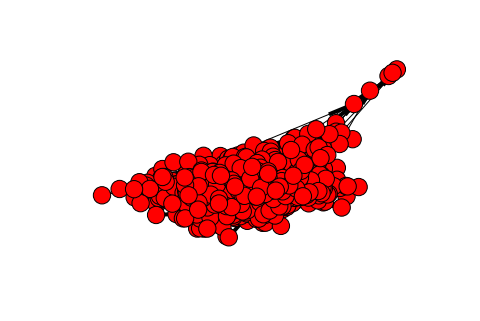

In [599]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()

In [ ]:
def create_propensity_table(Graph):
    edges = []
    treatment = []
    response = []
    X1 = []
    X2 = []
    for i in range(N_nodes):
        for j in range(i+1,N_nodes):
            if Graph.node[j]['previous_happiness'][0]> Graph.node[i]['previous_happiness'][0]:
                u,v = i,j
            else:
                u,v = j,i
                
            if (u,v) in Graph.edges():
                treatment.append(1)
                step_creation = Graph[u][v]['step_creation']
                edges.append((u,v))
                response.append(Graph.node[u]['happiness'] - Graph.node[u]['previous_happiness'][0])
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
            elif len(Graph.neighbors(u))==1 :
                edges.append((u,v))
                treatment.append(0)
                response.append(Graph.node[u]['happiness'] - Graph.node[u]['previous_happiness'][0])
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
                
            
                
    return pd.DataFrame({'Edges':edges,
                    'Treatment': treatment,
                    'Response': response,
                    'X1': X1,
                    'X2': X2})

In [ ]:
data = create_propensity_table(G)
data['X3'] = abs(data['X2']-data['X1'])


In [ ]:
propensity = LogisticRegression()
propensity = propensity.fit(data[['X1','X2','X3']], data.Treatment)
pscore = propensity.predict_proba(data[['X1','X2','X3']])[:,1] # The predicted propensities by the model
data['Propensity'] = pscore

In [ ]:
def Match(groups, propensity, caliper = 0.05):
    ''' 
    Inputs:
    groups = Treatment assignments.  Must be 2 groups
    propensity = Propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. For now, this is a caliper on the raw
            propensity; Austin reccommends using a caliper on the logit propensity.
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
        
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); N2 = N-N1
    g1, g2 = propensity[groups == 1].reset_index(drop=True), (propensity[groups == 0]).reset_index(drop=True)
    # Check if treatment groups got flipped - treatment (coded 1) should be the smaller
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN
    
    for m in morder:
        dist = abs(g1[m] - g2)
        if dist.min() <= caliper:
            matches[m] = int(dist.argmin())
            g2 = g2.drop(matches[m])
    return (matches)


In [ ]:
# stuff = Match(data.Treatment, data.Propensity)
# stuff


In [ ]:
# g1, g2 = data.Propensity[data.Treatment==1].reset_index(drop=True), data.Propensity[data.Treatment==0].reset_index(drop=True)
# zip(g1, g2[stuff])

In [ ]:
r1 = data[data.Treatment==1].reset_index(drop=True)
r2 = data[data.Treatment==0].reset_index(drop=True)
st=[int(x) for x in stuff if not math.isnan(g2[stuff][x])]
data2 = pd.concat([r1,r2.iloc[stuff]]).reset_index(drop=True)



In [ ]:
result = sm.ols(formula="Response ~ Treatment + X1", data=data2).fit()

In [ ]:
result.params